In [1]:
from mlutils import *
from tensorflow.keras import models, layers, callbacks
import tensorflow as tf


In [2]:
window_duration=0.1
sampling_freq=2000
selected_muscles=[1,2,3]


window_length=int(window_duration*sampling_freq)

In [10]:
subject_names=os.listdir(BASE_EXTRACTION_PATH)
print(subject_names)


def get_vel(angle, del_time):
    vel=np.zeros(len(angle))
    vel[:-1]=(angle[1:]-angle[:-1])/del_time
    vel[-1]=vel[-2]

    return vel

X_data=[]
y_data=[]

num_data=10 # per

for sub in subject_names:
    for f in range(1,5):
        t, ang, emg=read_extracted_combined_data(sub,f)
        emg=np.array(emg)
        vel_data=get_vel(ang,1/sampling_freq)
        for i in range(0,len(vel_data)-window_length,window_length):
            
            start=i

            emg_s=np.array(emg[:3])
            X_data.append(emg_s[:,start:start+window_length])
            y_data.append(np.mean(vel_data[start:start+window_length]))

X_data=np.array(X_data)


['Abhoy', 'Alok', 'Tushar']


In [11]:
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1],X_data.shape[2],1)
X_data.shape
y_data=np.array([y_data]).reshape(len(y_data),1)

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test=train_test_split(X_data, y_data)

In [13]:


class CNN_Regressor:
    def __init__(self, input_shape):
        self.model=models.Sequential()
        self.model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
        self.model.add(layers.MaxPool2D((1,2)))
        self.model.add(layers.Conv2D(64, (1,6),activation='relu'))
        self.model.add(layers.AvgPool2D(1,10))
        self.model.add(layers.Conv2D(128, (1,2),activation='relu'))
        self.model.add(layers.AvgPool2D(1,3))
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(64, activation='relu'))
        self.model.add(layers.Dense(1, activation='linear'))
        self.model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
        self.model.summary()

        self.history=None

    def fit(self,train_data, train_value,epochs=20, test_data=None, test_value=None):
        self.history=self.model.fit(train_data, train_value, epochs=epochs, validation_data=(test_data, test_value)) 
    
    def predict(self, test_data):
        test_data=tf.convert_to_tensor(test_data)
        return self.model.predict(test_data)
reg=CNN_Regressor((3,200,1))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 1, 198, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 99, 32)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 94, 64)         12352     
                                                                 
 average_pooling2d_2 (Averag  (None, 1, 10, 64)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 9, 128)         16512     
                                                                 
 average_pooling2d_3 (Averag  (None, 1, 3, 128)       

In [14]:
reg.fit(x_train,y_train,100, x_test, y_test)

Epoch 1/100


102/102 [==============================] - 1s 8ms/step - loss: 2807.5090 - val_loss: 2641.4712
Epoch 2/100
102/102 [==============================] - 1s 7ms/step - loss: 2791.4377 - val_loss: 2585.9375
Epoch 3/100
102/102 [==============================] - 1s 7ms/step - loss: 2733.1980 - val_loss: 2446.0754
Epoch 4/100
102/102 [==============================] - 1s 7ms/step - loss: 2592.1809 - val_loss: 2346.8040
Epoch 5/100
102/102 [==============================] - 1s 7ms/step - loss: 2475.6682 - val_loss: 2288.1018
Epoch 6/100
102/102 [==============================] - 1s 7ms/step - loss: 2478.3093 - val_loss: 2205.8347
Epoch 7/100
102/102 [==============================] - 1s 7ms/step - loss: 2455.4187 - val_loss: 2190.9397
Epoch 8/100
102/102 [==============================] - 1s 7ms/step - loss: 2420.0476 - val_loss: 2167.4326
Epoch 9/100
102/102 [==============================] - 1s 7ms/step - loss: 2373.2720 - val_loss: 2108.4124
Epoch 10/100
102/102 [===========================

1/1 [==============================] - 0s 17ms/step


Text(0, 0.5, 'Angular Velocity (Deg/s)')

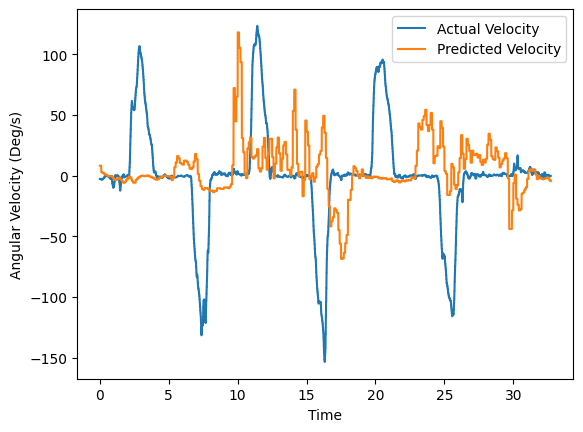

In [16]:
import matplotlib.pyplot as plt

t, angle, emg_sig=read_extracted_combined_data('Alok',2)

vel_data=get_vel(angle, 1/sampling_freq)
y_pred=np.zeros(len(vel_data))
for i in range(0,len(t),window_length):
    x_t=[emg_s[:,i:i+window_length]]
    if x_t[0].shape[1]==window_length:
        y_pred[i:i+window_length]=reg.predict(x_t)[0]

plt.plot(t,vel_data)
plt.plot(t,y_pred)
plt.legend(['Actual Velocity', 'Predicted Velocity'])
plt.xlabel('Time')
plt.ylabel('Angular Velocity (Deg/s)')